In [8]:
import torch
from torchvision import models
import torch.nn as nn
from ultralytics import YOLO
from PIL import Image
from torchvision import transforms

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
# YOLO model
yolo_model = YOLO("yolov8n.pt")  

# Stage 1 classifier (fruit type)
num_classes_type = 10
fruit_type_model = models.resnet18(pretrained=False)
fruit_type_model.fc = nn.Linear(fruit_type_model.fc.in_features, num_classes_type)
fruit_type_model.load_state_dict(torch.load("../models/fruit_type_resnet18.pth", map_location=device))
fruit_type_model.eval()


# Stage 2 classifier (fruit quality)
num_classes_quality = 2
fruit_quality_model = models.resnet18(pretrained=False)
dropout_rate_quality = 0.2  
if dropout_rate_quality > 0:
    fruit_quality_model.fc = nn.Sequential(
        nn.Dropout(dropout_rate_quality),
        nn.Linear(fruit_quality_model.fc.in_features, num_classes_quality)
    )
else:
    fruit_quality_model.fc = nn.Linear(fruit_quality_model.fc.in_features, num_classes_quality)
fruit_quality_model.load_state_dict(torch.load("../models/quality_resnet18.pth", map_location=device))
fruit_quality_model.eval()

# Preprocessing for ResNet18 classifiers
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

/home/daniel27/miniconda3/envs/mlenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daniel27/miniconda3/envs/mlenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
from PIL import Image, ImageDraw, ImageFont

fruit_type_names = ['apple', 'avocado', 'banana', 'kiwi', 'lemon', 'orange', 'pear', 'pomegranate', 'strawberry', 'watermelon']
fruit_quality_names = ['fresh', 'not fresh']

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def predict_single_image_with_visualization(img_path, yolo_model, fruit_type_model, fruit_type_names, fruit_quality_model, fruit_quality_names):
    img = Image.open(img_path).convert('RGB')
    results = yolo_model(img_path)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    # Prepare figure
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    
    for (x1, y1, x2, y2) in boxes:
        crop = img.crop((int(x1), int(y1), int(x2), int(y2)))
        input_tensor = preprocess(crop).unsqueeze(0)
        
        with torch.no_grad():
            type_logits = fruit_type_model(input_tensor)
            fruit_type_pred = int(type_logits.argmax(dim=1).item())
            fruit_type_name = fruit_type_names[fruit_type_pred]
        with torch.no_grad():
            quality_logits = fruit_quality_model(input_tensor)
            fruit_quality_pred = int(quality_logits.argmax(dim=1).item())
            quality_name = fruit_quality_names[fruit_quality_pred]
        
        label = f"{fruit_type_name}, {quality_name}"
        # Draw rectangle
        rect = patches.Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        # Draw label background
        ax.text(x1, y1-5, label, fontsize=12, color='yellow', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [23]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def predict_batch_images_and_save_from_dir(img_dir, yolo_model, fruit_type_model, fruit_quality_model,
                                 fruit_type_names, fruit_quality_names, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    # Collect all image paths in the directory
    img_paths = [
        os.path.join(img_dir, fname)
        for fname in os.listdir(img_dir)
        if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    results_list = []
    for img_path in img_paths:
        img = Image.open(img_path).convert('RGB')
        results = yolo_model(img_path)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(img)
        img_detections = []
        for (x1, y1, x2, y2) in boxes:
            crop = img.crop((int(x1), int(y1), int(x2), int(y2)))
            input_tensor = preprocess(crop).unsqueeze(0)
            with torch.no_grad():
                type_logits = fruit_type_model(input_tensor)
                fruit_type_pred = int(type_logits.argmax(dim=1).item())
                fruit_type_name = fruit_type_names[fruit_type_pred]
            with torch.no_grad():
                quality_logits = fruit_quality_model(input_tensor)
                fruit_quality_pred = int(quality_logits.argmax(dim=1).item())
                quality_name = fruit_quality_names[fruit_quality_pred]
            label = f"{fruit_type_name}, {quality_name}"
            rect = patches.Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-5, label, fontsize=12, color='yellow', bbox=dict(facecolor='red', alpha=0.5))
            img_detections.append({
                'box': [int(x1), int(y1), int(x2), int(y2)],
                'fruit_type': fruit_type_name,
                'fruit_quality': quality_name
            })
        ax.axis('off')
        plt.tight_layout()
        # Save figure to the output folder
        img_basename = os.path.splitext(os.path.basename(img_path))[0]
        output_path = os.path.join(output_folder, img_basename + '_vis.png')
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        results_list.append({
            'image': img_path,
            'detections': img_detections,
            'visualization': output_path
        })
    return results_list



image 1/1 /mnt/c/Users/xiezh/Desktop/Com Vision/AAI3001-Project2/yolo/../dataset/test_images/fruitsrec_Apple_Apple 0444.png: 448x640 5 apples, 77.8ms
Speed: 5.4ms preprocess, 77.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


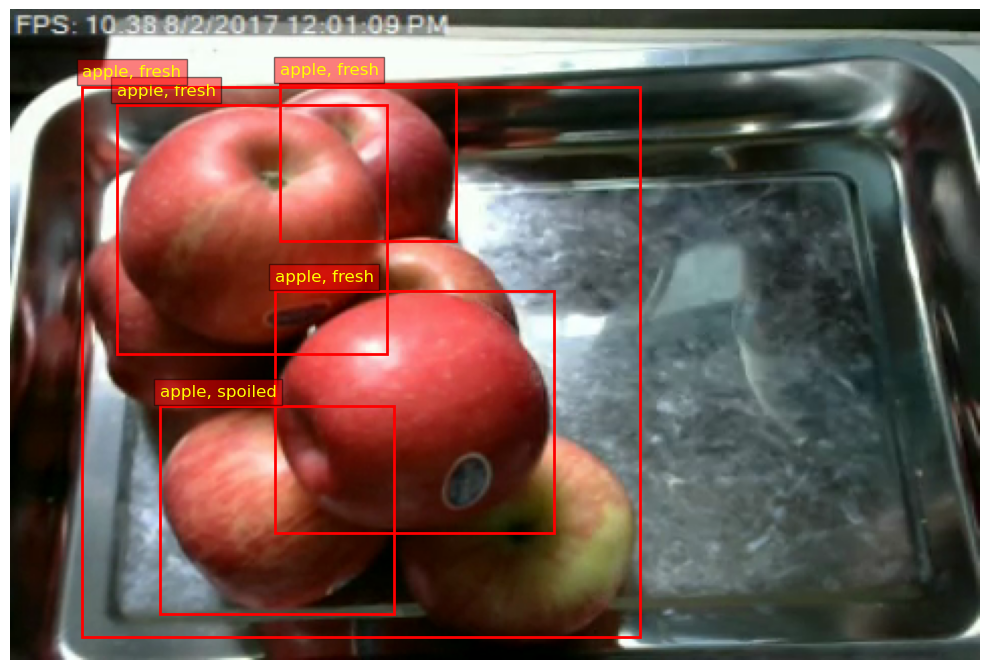

In [19]:
predict_single_image_with_visualization("../dataset/test_images/fruitsrec_Apple_Apple 0444.png", yolo_model, fruit_type_model, fruit_type_names, fruit_quality_model, fruit_quality_names)

In [ ]:
predict_batch_images_and_save_from_dir(
    "../dataset/test_images/",
    yolo_model,
    fruit_type_model,
    fruit_quality_model,
    fruit_type_names,
    fruit_quality_names,
    output_folder="../test_results/")

IsADirectoryError: [Errno 21] Is a directory: '.'